In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

%matplotlib widget
from tqdm import trange

import physicsConsts as c
from simulation_functions import get_AM3, blastwave, powerlaw_array
from plotting_functions import plot_spectrum, plot_coolingtimes, Eobs_av, dens2flux_av
import setFigureConfig as sfc

from colorschemes import get_comp_cols
compcols = get_comp_cols()


# set up AM3

In [2]:
am3 = get_AM3(exp=1, hadronic=1, qsyn=1) # expansion needed for time dependent method
am3.init_kernels()

init. AM3 kernels:
AM3 has the following switches (at step: 0)
estimate maximum energies: 0
parse sed components: 1
escape: 1
expansion: 1
adiabatic: 1
synchrotron:
  e+/-: 1  (em..: 1, cool.: 1)
  protons:1  (em..: 1, cool.: 1)
  pions:1  (em..: 1, cool.: 1)
  muons:1  (em..: 1, cool.: 1)
  syn-self-abs.:1
  e+/- quantum-syn.:1
inv. Compton:
  e+/-: 1  (em.. : 1, cool.: 1 (continuous))
  photon loss due to upscattering: 1
  protons:1  (em.. (step approx.): 1, no cooling)
  pions:1  (em.. (step approx.): 1, cont. cool.: 1)
  muons:1  (em.. (step approx.): 1, cont. cool.: 1)
pair prod. (gamma+gamma->e+e)1  (photon loss.: 1, e+/- source (feedback): 1(opt. 14-bin kernel))
'hadronic' processes (below): 1
 Pion decay: 1 Muon decay:1)
proton Bethe-Heitler: 1  (em..: 1, cool.: 1)
proton photo-pion: 1  (em..: 1, cool.: 1, photon loss: 1)
proton p-p: 1  (em..: 1 , cool.: 1)

AM3 params (comoving):
escape_timescale: 1e+06 s
  with fractions: (protons: 1, neutrons: 1, pions: 1, muons: 1, neutrino

In [3]:
# short cuts for energy grids
Ee_eV = am3.get_egrid_lep()
Ee_erg = Ee_eV * c.eV2erg
Eg_eV = am3.get_egrid_photons()
Eg_erg = Eg_eV * c.eV2erg
Ep_eV = am3.get_egrid_had()
Ep_erg = Ep_eV * c.eV2erg
En_eV = am3.get_egrid_neutrinos()
En_erg = En_eV * c.eV2erg

## set parameters

In [4]:
z = 0.1
Gamma = 10**1.7
n = 100 # cm^-3
t_obs = 1e3 # s
epsilon_B = 10**-1
epsilon_e = 10**-4.5
epsilon_p = 10**-3
p = 2
Emin = 10**9 # eV
eta = 1
Ntdyn = 5
fdt = 1e-2 # time step as a fraction of dynamical time


## run simulation

In [5]:
am3.clear_particle_densities()
am3.set_electron_accel_factor(eta)
am3.set_proton_accel_factor(eta)
am3.set_escape_fraction_charged_particles(0)
am3.set_escape_fraction_neutral_particles(1)

B_last = 0 # updates magnetic field for sure

N_evo = int(Ntdyn/fdt)

for i in trange(N_evo):
    # log time steps
    t_obs_evo = (1-fdt)**(N_evo-i -1) * t_obs
    t_dyn, n_target, p_ram_eval, B = blastwave(
        t_obs_evo, Gamma, n, t_obs, epsilon_B)

    # update parameters
    am3.set_escape_timescale(t_dyn)
    am3.set_expansion_timescale(t_dyn)
    am3.set_solver_time_step(fdt * t_dyn)
    am3.set_pp_target_proton_density(n_target)
    # only update quantum syn kernel when field changed significantly (slow)
    if abs(B_last-B)/B_last > 0.1:
        am3.set_mag_field(B)
        B_last = B

    # estimate max. energy
    if i>0:
        am3.estimate_max_electron_energy()
        Eemax = am3.get_estimated_electron_emax()
        am3.estimate_max_proton_energy()
        Epmax = am3.get_estimated_proton_emax()
    else: # use small value for first step
        Eemax = 10*Emin
        Epmax = 10*Emin
    # update injection spectra
    am3.set_injection_rate_electrons(
        Ee_erg*powerlaw_array(
            Ee_erg, Emin*c.eV2erg, Eemax*c.eV2erg, p, epsilon_e*p_ram_eval / t_dyn))
    am3.set_injection_rate_protons(
        Ep_erg*powerlaw_array(
            Ep_erg, Emin*c.eV2erg, Epmax*c.eV2erg, p, epsilon_p*p_ram_eval / t_dyn))
    
    am3.evolve_step()


  0%|          | 0/500 [00:00<?, ?it/s]

/lustre/fs23/group/that/mklinger/conda/miniconda3/envs/am3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
100%|██████████| 500/500 [03:25<00:00,  2.44it/s]


# plots

## timescales

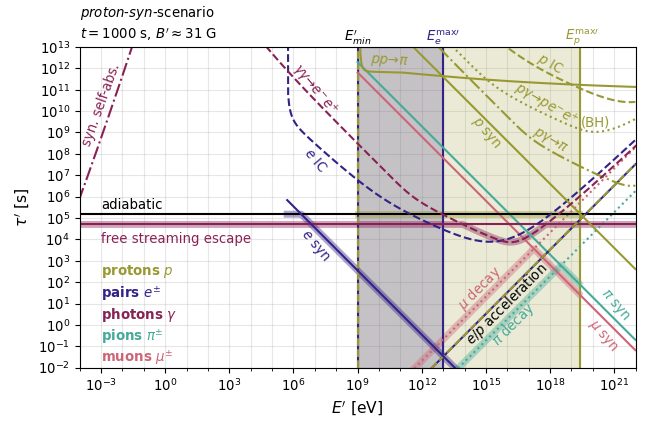

In [13]:
%matplotlib widget
# for i in range(4):
i=4
sfc.fullWidth(aspectRatio=0.65, alpha=0.8)
fig, ax = plt.subplots() #figsize=(6,3))
cgamma = compcols["pp"]

iphoton = 0
iproton = 1
icascade = 2
if i>icascade+1:
    inds_p = (Ep_eV< am3.get_estimated_proton_emax())
    tdom_p = np.minimum(am3.get_t_proton_adiabatic(), am3.get_t_proton_syn())
    ax.loglog(Ep_eV[inds_p], tdom_p[inds_p], alpha=0.4, color=compcols["p"], lw=5)

    tdom_mu = np.minimum(
        np.minimum(am3.get_t_proton_adiabatic(), am3.get_t_muon_syn()),
        am3.get_t_muon_decay())
    ax.loglog(Ep_eV[inds_p], tdom_mu[inds_p], alpha=0.4, color=compcols["mu"], lw=5)

    tdom_pi = np.minimum(
        np.minimum(am3.get_t_proton_adiabatic(), am3.get_t_pion_syn()),
        am3.get_t_pion_decay())
    ax.loglog(Ep_eV[inds_p], tdom_pi[inds_p], alpha=0.4, color=compcols["pi"], lw=5)
    if i<iproton:
        inds_e = (Ee_eV< am3.get_estimated_electron_emax())
    elif i>=iproton:
        inds_e = (Ee_eV< am3.get_estimated_proton_emax())

    if i>0:
        tdom_e = np.minimum(am3.get_t_pair_adiabatic(), am3.get_t_pair_syn())
        ax.loglog(Ee_eV[inds_e], tdom_e[inds_e], alpha=0.4, color=compcols["in"], lw=5)

    tdom_g = np.minimum(am3.get_t_photon_escape(), am3.get_t_photon_annihilation())
    ax.loglog(Eg_eV, tdom_g, alpha=0.4, color=cgamma, lw=5)


ax = plot_coolingtimes(
    ax, Ep_eV, Ee_eV, Eg_eV, 0, Emin, Emin,
    [am3.get_t_proton_syn()*(i>iproton)], [am3.get_t_proton_adiabatic()],
    [am3.get_t_proton_acceleration()*(i>iproton)], [am3.get_t_proton_compton()*(i>iproton)],
    [am3.get_t_proton_bethe_heitler()*(i>iproton)], [am3.get_t_proton_photopion()*(i>iproton)],
    [am3.get_t_proton_proton_proton()*(i>iproton)], [am3.get_t_pair_syn()],
    [am3.get_t_pair_compton()], [am3.get_t_pair_acceleration()],
    [am3.get_t_photon_escape()*(i>iphoton)], [am3.get_t_photon_annihilation()*(i>iphoton)],
    [am3.get_t_photon_ssa()*(i>iphoton)], 
    am3.get_t_pion_decay()*(i>icascade), am3.get_t_muon_decay()*(i>icascade), leptonic=i<=iproton,
    ylim=[1e-2, 1e13], xlim=[1e-4, 1e22], cel=compcols["in"], cproton=compcols["p"],
    cpion=compcols["pi"], cmuon=compcols["mu"], cgamma=cgamma, pions=(i>icascade), muons=(i>icascade)
)
if i>iphoton:
    ax.text(1e-3, 2e10, r"syn. self-abs.", color=cgamma, va="center", ha="center", zorder=100, rotation=70)
    ax.text(1e7, 1e11, r"$\gamma\gamma \to e^{-}e^{+}$", color=cgamma, va="center", ha="center", zorder=100, rotation=-50)
    ax.text(1e-3, 1e4, r"free streaming escape", color=cgamma, va="center", ha="left", zorder=100, rotation=0)
ax.text(1e-3, 4e5, r"adiabatic", color="k", va="center", ha="left", zorder=100, rotation=0)

ax.text(1e7, 5e7, r"$e$ IC", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e7, 5e3, r"$e$ syn", color=compcols["in"], va="center", ha="center", zorder=100, rotation=-50)
ax.text(1e9, 3e13, r"$E_{min}'$", color="k", va="center", ha="center", zorder=100, rotation=0)
ax.text(1e13, 3e13, r"$E_e^{\mathrm{max}\prime}$", color=compcols["in"], va="center", ha="center", zorder=100, rotation=0)

if i>iproton:
    ax.text(3e19, 3e13, r"$E_p^{\mathrm{max}\prime}$", color=compcols["p"], va="center", ha="center", zorder=100, rotation=0)
    ax.text(1e15, 9e8, r"$p$ syn", color=compcols["p"], va="center", ha="center", zorder=100, rotation=-50)

    ax.text(1e18, 1.5e12, r"$p$ IC", color=compcols["p"], va="center", ha="center", zorder=100, rotation=-30)
    ax.text(7e17, 2e10, r"$p\gamma\to p e^{-}e^{+}$", color=compcols["p"], va="center", ha="center", zorder=100, rotation=-30)
    ax.text(1.3e20, 3e9, r"(BH)", color=compcols["p"], va="center", ha="center", zorder=100, rotation=0)
    ax.text(1e18, 4e8, r"$p\gamma\to\pi$", color=compcols["p"], va="center", ha="center", zorder=100, rotation=-30)
    ax.text(3e10, 2e12, r"$pp\to\pi$", color=compcols["p"], va="center", ha="center", zorder=100, rotation=-3)

if i<=iproton:
    ax.text(1e16, 9, r"$e$ acceleration", color=compcols["in"], va="center", ha="center", zorder=100, rotation=45)
else:
    ax.text(1e16, 9, r"$e/p$ acceleration", color="k", va="center", ha="center", zorder=100, rotation=45)

if i>icascade:
    ax.text(3e20, 3e-1, r"$\mu$ syn", color=compcols["mu"], va="center", ha="center", zorder=100, rotation=-50)
    ax.text(1e21, 8, r"$\pi$ syn", color=compcols["pi"], va="center", ha="center", zorder=100, rotation=-50)
    ax.text(2e16, 1, r"$\pi$ decay", color=compcols["pi"], va="center", ha="center", zorder=100, rotation=45)
    ax.text(5e14, 5e1, r"$\mu$ decay", color=compcols["mu"], va="center", ha="center", zorder=100, rotation=45)
if i>iproton:
    ax.text(1e-3, 3e2, r"protons $p$", color=compcols["p"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
ax.text(1e-3, 3e1, r"pairs $e^{\pm}$", color=compcols["in"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
if i>iphoton:
    ax.text(1e-3, 3e0, r"photons $\gamma$", color=cgamma, va="center", ha="left", zorder=100, rotation=0, weight="bold")
if i>icascade:
    ax.text(1e-3, 3e-1, r"pions $\pi^{\pm}$", color=compcols["pi"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
    ax.text(1e-3, 3e-2, r"muons $\mu^{\pm}$", color=compcols["mu"], va="center", ha="left", zorder=100, rotation=0, weight="bold")
title_string = r"$proton$-$syn$-scenario" + "\n"
title_string += r"$t=" + f"{1000}"
title_string += r"$ s"
if B is not None:
    title_string += r", $B'\approx %.0f \; \mathrm{G}$" %(B)
# title_string += r", $\eta = %g $" %(eta)
# title_string += "$"
ax.set_title(title_string, loc="left")
fig.tight_layout()
sfc.saveFigure(fig, f"timescales/psyn_timescales_const_{i}", dpi=500)

## particle spectra

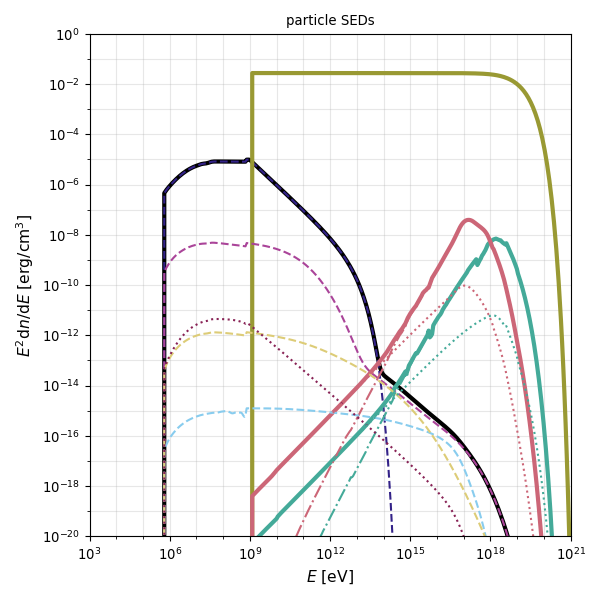

In [34]:
i = 8
fig, ax = plt.subplots(figsize=(6,6))
alpha_dom = 0.4

ax.loglog(Ee_eV, Ee_erg*am3.get_pairs(), c="k", lw=3)
ax.loglog(Ee_eV, Ee_erg*am3.get_pairs_injected(), c=compcols["in"], ls="--")
if i ==0:
    ax.fill_between(
        Ee_eV, np.zeros_like(Ee_eV), Ee_erg*am3.get_pairs_injected(),
        color=compcols["in"], alpha=alpha_dom, zorder=5)

if i>0:
    ax.loglog(Ep_eV, Ep_erg*am3.get_protons(), c=compcols["p"], lw=3)
if i ==1:
    ax.fill_between(
        Ep_eV, np.zeros_like(Ep_eV), Ep_erg*am3.get_protons(),
        color=compcols["p"], alpha=alpha_dom, zorder=5)

if i>1:
    ax.loglog(Ee_eV, Ee_erg*am3.get_pairs_annihilation(), c=compcols["pair"], ls="--")
if i ==2:
    ax.fill_between(
        Ee_eV, np.zeros_like(Ee_eV), Ee_erg*am3.get_pairs_annihilation(),
        color=compcols["pair"], alpha=alpha_dom, zorder=5)

if i>2:
    ax.loglog(Ep_eV, Ep_erg*am3.get_pions(), c=compcols["pi"], lw=3)
    ax.loglog(Ep_eV, Ep_erg*am3.get_pions_photopion(), c=compcols["pi"], ls="-.")
if i ==3:
    ax.fill_between(
        Ep_eV, np.zeros_like(Ep_eV), Ep_erg*am3.get_pions_photopion(),
        color=compcols["pi"], alpha=alpha_dom, zorder=5)

if i>3:
    ax.loglog(Ep_eV, Ep_erg*am3.get_muons(), c=compcols["mu"], lw=3)
    ax.loglog(Ep_eV, Ep_erg*am3.get_muons_photopion(), c=compcols["mu"], ls="-.")
if i ==4:
    ax.fill_between(
        Ep_eV, np.zeros_like(Ep_eV), Ep_erg*am3.get_muons_photopion(),
        color=compcols["mu"], alpha=alpha_dom, zorder=5)
    
if i>4:
    ax.loglog(Ee_eV, Ee_erg*am3.get_pairs_photopion(), c=compcols["pg"], ls="--")
if i ==5:
    ax.fill_between(
        Ee_eV, np.zeros_like(Ee_eV), Ee_erg*am3.get_pairs_photopion(),
        color=compcols["pg"], alpha=alpha_dom, zorder=5)

if i>5:
    ax.loglog(Ee_eV, Ee_erg*am3.get_pairs_bethe_heitler(), c=compcols["bh"], ls="--")
if i ==6:
    ax.fill_between(
        Ee_eV, np.zeros_like(Ee_eV), Ee_erg*am3.get_pairs_bethe_heitler(),
        color=compcols["bh"], alpha=alpha_dom, zorder=5)

if i>6:
    ax.loglog(Ee_eV, Ee_erg*am3.get_pairs_proton_proton(), c=compcols["pp"], ls=":")    
    ax.loglog(Ep_eV, Ep_erg*am3.get_pions_proton_proton(), c=compcols["pi"], ls=":")
    ax.loglog(Ep_eV, Ep_erg*am3.get_muons_proton_proton(), c=compcols["mu"], ls=":")

if i ==7:
    ax.fill_between(
        Ee_eV, np.zeros_like(Ee_eV), Ee_erg*am3.get_pairs_proton_proton(),
        color=compcols["pp"], alpha=alpha_dom, zorder=5)  
    ax.fill_between(
        Ep_eV, np.zeros_like(Ep_eV), Ep_erg*am3.get_muons_proton_proton(),
        color=compcols["mu"], alpha=alpha_dom, zorder=5)
    ax.fill_between(
        Ep_eV, np.zeros_like(Ep_eV), Ep_erg*am3.get_pions_proton_proton(),
        color=compcols["pi"], alpha=alpha_dom, zorder=5)  

# ax.loglog(En_eV, En_erg*am3.get_neutrinos(), c="k", lw=3)

ax.set_title("particle SEDs")
ax.grid(alpha=0.3, which="both")
ax.set_ylim(1e-20, 1)
ax.set_yticks(10**np.arange(-20, 1., 2))
ax.set_yticks(10**np.arange(-20, 1., 1), minor=True)
ax.set_yticklabels(["" for i in np.arange(-20, 1., 1)], minor=True)
ax.set_xlim(1e3, 1e21)
ax.set_xticks(10**np.arange(3, 21.5, 3))
ax.set_xticks(10**np.arange(3, 21., 1), minor=True)
ax.set_xticklabels(["" for i in np.arange(3, 21., 1)], minor=True)
ax.set_xlabel(r"$E$ [eV]")
ax.set_ylabel(r"$E^2 \mathrm{d} n/\mathrm{d} E$ [erg/cm$^3$]")
fig.tight_layout()
sfc.saveFigure(fig, f"particleSED/particles_SED_buildup_{i}")

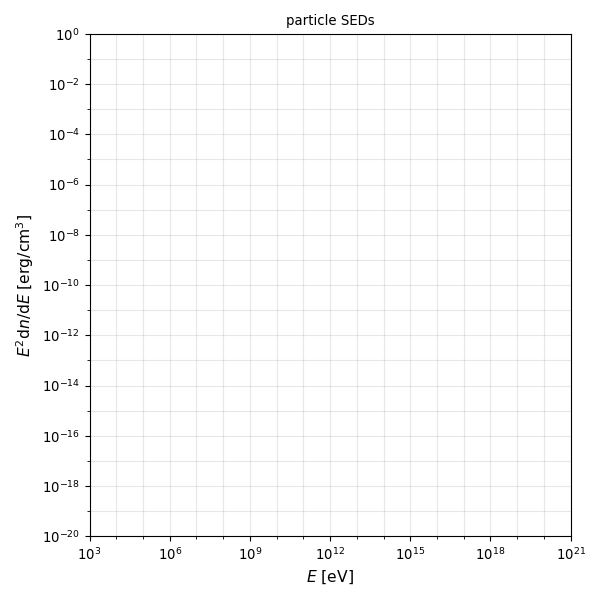

In [35]:
fig, ax = plt.subplots(figsize=(6,6))

ax.loglog(Ee_eV, Ee_erg*am3.get_pairs()*1e-20, c="k", lw=3)

ax.set_title("particle SEDs")
ax.grid(alpha=0.3, which="both")
ax.set_ylim(1e-20, 1)
ax.set_yticks(10**np.arange(-20, 1., 2))
ax.set_yticks(10**np.arange(-20, 1., 1), minor=True)
ax.set_yticklabels(["" for i in np.arange(-20, 1., 1)], minor=True)
ax.set_xlim(1e3, 1e21)
ax.set_xticks(10**np.arange(3, 21.5, 3))
ax.set_xticks(10**np.arange(3, 21., 1), minor=True)
ax.set_xticklabels(["" for i in np.arange(3, 21., 1)], minor=True)
ax.set_xlabel(r"$E$ [eV]")
ax.set_ylabel(r"$E^2 \mathrm{d} n/\mathrm{d} E$ [erg/cm$^3$]")
fig.tight_layout()
sfc.saveFigure(fig, f"particleSED/particles_SED_buildup_empty")

## photon spectra

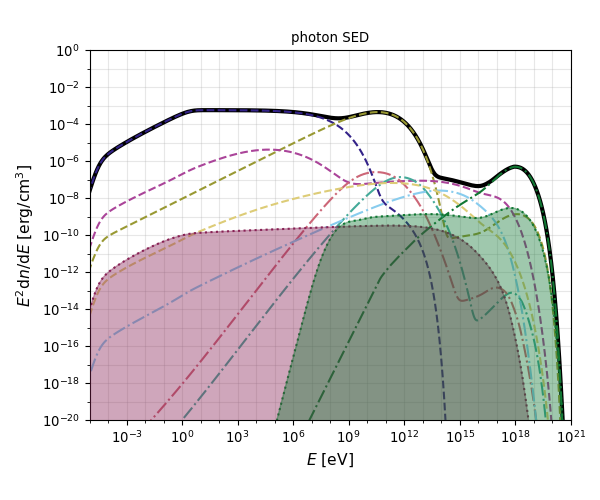

In [24]:
i = 9
alpha_dom = 0.4
# for i in range(8):
if True:
    
    fig, ax = plt.subplots(figsize=(6,5))


    ax.loglog(Eg_eV, Eg_erg*am3.get_photons(), c="k", lw=3)

    if i==1:
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_injected_electrons_syn(), c=compcols["in"], ls="--")
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_injected_electrons_compton(), c=compcols["in"], ls="--")
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_injected_electrons_syn(),
            color=compcols["in"], alpha=alpha_dom, zorder=5)
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_injected_electrons_compton(),
            color=compcols["in"], alpha=alpha_dom, zorder=5)
    if i>1:
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_injected_electrons_syn_compton(), c=compcols["in"], ls="--")
    if i==2:
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_injected_electrons_syn_compton(),
            color=compcols["in"], alpha=alpha_dom, zorder=5)
    if i>2:
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_protons_syn_compton(), c=compcols["p"], ls="--")
    if i==3:
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_protons_syn_compton(),
            color=compcols["p"], alpha=alpha_dom, zorder=5)
    if i>3:
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_annihilation_pairs_syn_compton(), c=compcols["pair"], ls="--")
    if i==4:
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_annihilation_pairs_syn_compton(),
            color=compcols["pair"], alpha=alpha_dom, zorder=5)
    if i>4:
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_pi0_decay_photopion(), c=compcols["pi0"], ls="-.")
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_pions_syn_compton(), c=compcols["pi"], ls="-.")
    if i==5:
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_pi0_decay_photopion(),
            color=compcols["pi0"], alpha=alpha_dom, zorder=5)
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_pions_syn_compton(),
            color=compcols["pi"], alpha=alpha_dom, zorder=5)
    if i>5:
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_muons_syn_compton(), c=compcols["mu"], ls="-.")
    if i==6:
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_muons_syn_compton(),
            color=compcols["mu"], alpha=alpha_dom, zorder=5)

    if i>6:
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_photo_pion_pairs_syn_compton(), c=compcols["pg"], ls="-.")
    if i==7:
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_photo_pion_pairs_syn_compton(),
            color=compcols["pg"], alpha=alpha_dom, zorder=5)
    if i>7:
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_bethe_heitler_pairs_syn_compton(), c=compcols["bh"], ls="--")
    if i==8:
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_bethe_heitler_pairs_syn_compton(),
            color=compcols["bh"], alpha=alpha_dom, zorder=5)
    if i > 8:
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_proton_proton_pairs_syn_compton(), c=compcols["pp"], ls=":")
        ax.loglog(Eg_eV, Eg_erg*am3.get_photons_pi0_decay_proton_proton(), c=compcols["pi0"], ls=":")
    if i==9:
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_proton_proton_pairs_syn_compton(),
            color=compcols["pp"], alpha=alpha_dom, zorder=5)
        ax.fill_between(
            Eg_eV, np.zeros_like(Eg_eV), Eg_erg*am3.get_photons_pi0_decay_proton_proton(),
            color=compcols["pi0"], alpha=alpha_dom, zorder=5)


    ax.set_title("photon SED")
    ax.set_aspect("equal")
    ax.grid(alpha=0.3, which="both")
    ax.set_ylim(1e-20, 1)
    ax.set_yticks(10**np.arange(-20, 1., 2))
    ax.set_yticks(10**np.arange(-20, 1., 1), minor=True)
    ax.set_yticklabels(["" for i in np.arange(-20, 1., 1)], minor=True)
    ax.set_xlim(1e-5, 1e21)
    ax.set_xticks(10**np.arange(-3, 21.5, 3))
    ax.set_xticks(10**np.arange(-5, 21., 1), minor=True)
    ax.set_xticklabels(["" for i in np.arange(-5, 21., 1)], minor=True)
    ax.set_xlabel(r"$E$ [eV]")
    ax.set_ylabel(r"$E^2 \mathrm{d} n/\mathrm{d} E$ [erg/cm$^3$]")
    fig.tight_layout()
    sfc.saveFigure(fig, f"photonSED/SED_buildup_{i}")

## neutrino spectra

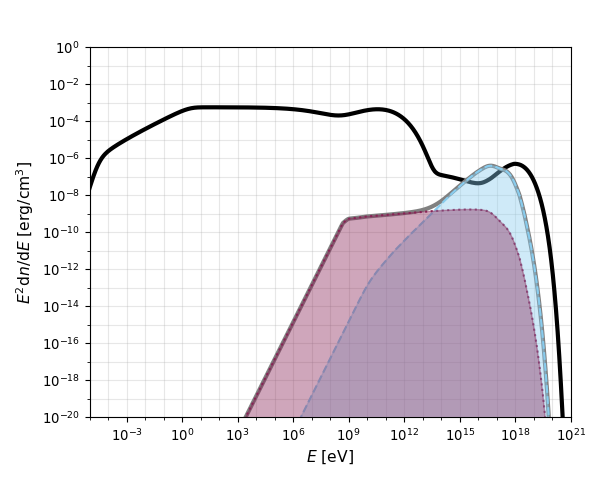

In [36]:

fig, ax = plt.subplots(figsize=(6,5))
alpha_dom=0.4

ax.loglog(Eg_eV, Eg_erg*am3.get_photons(), c="k", lw=3)

ax.loglog(En_eV, En_erg*am3.get_neutrinos(), c="grey", lw=3)
ax.loglog(En_eV, En_erg*am3.get_neutrinos_photopion(), c=compcols["pg"], ls="--")
ax.loglog(En_eV, En_erg*am3.get_neutrinos_proton_proton(), c=compcols["pp"], ls=":")

ax.fill_between(
    En_eV, np.zeros_like(En_eV), En_erg*am3.get_neutrinos_photopion(),
    color=compcols["pg"], alpha=alpha_dom, zorder=5)
ax.fill_between(
    En_eV, np.zeros_like(En_eV), En_erg*am3.get_neutrinos_proton_proton(),
    color=compcols["pp"], alpha=alpha_dom, zorder=5)


# ax.set_title("photon SED")
ax.set_aspect("equal")
ax.grid(alpha=0.3, which="both")
ax.set_ylim(1e-20, 1)
ax.set_yticks(10**np.arange(-20, 1., 2))
ax.set_yticks(10**np.arange(-20, 1., 1), minor=True)
ax.set_yticklabels(["" for i in np.arange(-20, 1., 1)], minor=True)
ax.set_xlim(1e-5, 1e21)
ax.set_xticks(10**np.arange(-3, 21.5, 3))
ax.set_xticks(10**np.arange(-5, 21., 1), minor=True)
ax.set_xticklabels(["" for i in np.arange(-5, 21., 1)], minor=True)
ax.set_xlabel(r"$E$ [eV]")
ax.set_ylabel(r"$E^2 \mathrm{d} n/\mathrm{d} E$ [erg/cm$^3$]")
fig.tight_layout()
sfc.saveFigure(fig, f"photonSED/SED_buildup_neutrinos")

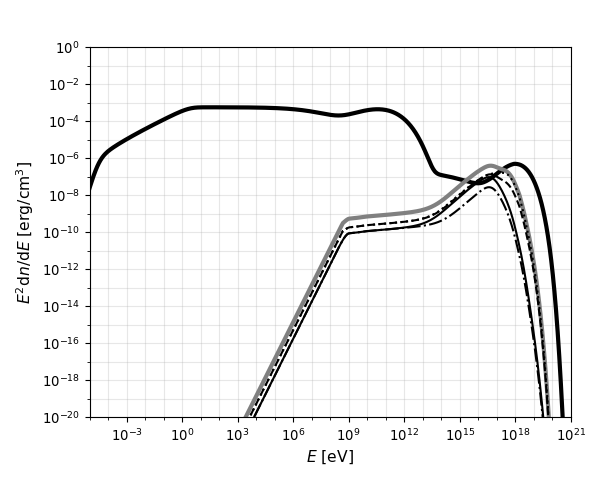

In [37]:

fig, ax = plt.subplots(figsize=(6,5))


ax.loglog(Eg_eV, Eg_erg*am3.get_photons(), c="k", lw=3)

ax.loglog(En_eV, En_erg*am3.get_neutrinos(), c="grey", lw=3)
ax.loglog(En_eV, En_erg*am3.get_electron_neutrinos(), c="k", ls="-")
ax.loglog(En_eV, En_erg*am3.get_electron_anti_neutrinos(), c="k", ls="-.")
ax.loglog(En_eV, En_erg*am3.get_muon_neutrinos(), c="k", ls=":")
ax.loglog(En_eV, En_erg*am3.get_muon_anti_neutrinos(), c="k", ls="--")
# ax.loglog(En_eV, En_erg*am3.get_neutrinos_proton_proton(), c=compcols["pp"], ls=":")


# ax.set_title("photon SED")
ax.set_aspect("equal")
ax.grid(alpha=0.3, which="both")
ax.set_ylim(1e-20, 1)
ax.set_yticks(10**np.arange(-20, 1., 2))
ax.set_yticks(10**np.arange(-20, 1., 1), minor=True)
ax.set_yticklabels(["" for i in np.arange(-20, 1., 1)], minor=True)
ax.set_xlim(1e-5, 1e21)
ax.set_xticks(10**np.arange(-3, 21.5, 3))
ax.set_xticks(10**np.arange(-5, 21., 1), minor=True)
ax.set_xticklabels(["" for i in np.arange(-5, 21., 1)], minor=True)
ax.set_xlabel(r"$E$ [eV]")
ax.set_ylabel(r"$E^2 \mathrm{d} n/\mathrm{d} E$ [erg/cm$^3$]")
fig.tight_layout()
sfc.saveFigure(fig, f"photonSED/SED_buildup_neutrinos_flavour")